In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
import glob
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Conv2D, Dense, Flatten ,Dropout ,MaxPooling2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras import layers, Sequential
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')

In [4]:
import tensorflow as tf

IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/Tumour/train",
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/Tumour/valid",
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/Tumour/test",
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 1695 files belonging to 4 classes.
Found 502 files belonging to 4 classes.
Found 246 files belonging to 4 classes.


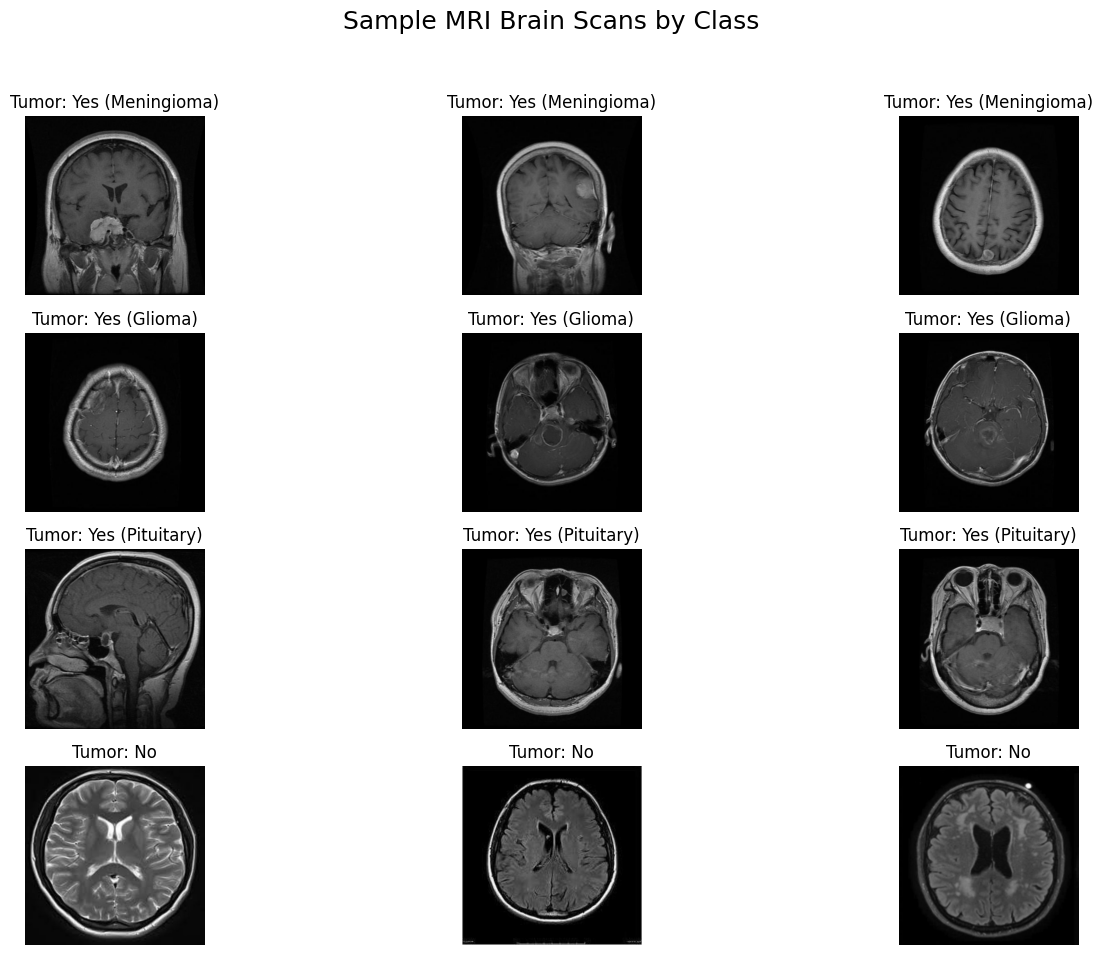

In [5]:
import matplotlib.pyplot as plt
import os
import cv2

plt.figure(figsize=(15, 10))
plt.suptitle("Sample MRI Brain Scans by Class", fontsize=18)

# Define the base directory and class names
base_dir = "/content/drive/MyDrive/Tumour/train"
class_names = ['meningioma', 'glioma', 'pituitary', 'no_tumor']

# Function to load sample images
def load_sample_images(directory, num_samples=3):
    images = []
    image_files = os.listdir(directory)
    random.shuffle(image_files) # Shuffle to get random samples
    for i in range(min(num_samples, len(image_files))):
        img_path = os.path.join(directory, image_files[i])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB for matplotlib
        images.append(img)
    return images

# Load sample images for each class
meningioma_samples = load_sample_images(os.path.join(base_dir, 'meningioma'))
glioma_samples = load_sample_images(os.path.join(base_dir, 'glioma'))
pituitary_samples = load_sample_images(os.path.join(base_dir, 'pituitary'))
no_tumor_samples = load_sample_images(os.path.join(base_dir, 'no_tumor'))


# Show meningioma tumor images
for i in range(min(3, len(meningioma_samples))):
    plt.subplot(4, 3, i + 1)
    plt.imshow(meningioma_samples[i])
    plt.title("Tumor: Yes (Meningioma)")
    plt.axis('off')

# Show glioma tumor images
for i in range(min(3, len(glioma_samples))):
    plt.subplot(4, 3, i + 4)
    plt.imshow(glioma_samples[i])
    plt.title("Tumor: Yes (Glioma)")
    plt.axis('off')

# Show pituitary tumor images
for i in range(min(3, len(pituitary_samples))):
    plt.subplot(4, 3, i + 7)
    plt.imshow(pituitary_samples[i])
    plt.title("Tumor: Yes (Pituitary)")
    plt.axis('off')

# Show no tumor images
for i in range(min(3, len(no_tumor_samples))):
    plt.subplot(4, 3, i + 10)
    plt.imshow(no_tumor_samples[i])
    plt.title("Tumor: No")
    plt.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # leaves space for suptitle
plt.show()

In [7]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))


In [8]:
print(train_ds)

<_MapDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 classes: meningioma, glioma, pituitary, no_tumor
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,156 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:

# Define the callbacks function
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.95:
            print("\n An acceptable level has been reached, training is cancelled")
            self.model.stop_training = True

back = myCallback()

In [11]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[back]
)

Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 271s 5s/step - accuracy: 0.4787 - loss: 1.2151 - val_accuracy: 0.6992 - val_loss: 0.7477
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.7253 - loss: 0.7496 - val_accuracy: 0.7689 - val_loss: 0.5836
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.7904 - loss: 0.5710 - val_accuracy: 0.7171 - val_loss: 0.6591
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.8037 - loss: 0.5025 - val_accuracy: 0.8008 - val_loss: 0.5277
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.8551 - loss: 0.3882 - val_accuracy: 0.8466 - val_loss: 0.4319
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.8760 - loss: 0.3447 - val_accuracy: 0.8606 - val_loss: 0.3997
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9048 - loss: 0.2623 - val_accuracy: 0.8526 - val_loss: 0.4541
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9159 - loss: 0.2357 - val_accuracy: 0.8924 -

In [12]:
x_test = []
y_test = []

for images, labels in test_ds:
    x_test.append(images.numpy())
    y_test.append(labels.numpy())

# Convert to NumPy arrays
x_test = np.concatenate(x_test)
y_test = np.concatenate(y_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 251ms/step

Classification Report:

              precision    recall  f1-score   support

    No Tumor       0.97      0.90      0.94        80
  Meningioma       0.79      0.87      0.83        63
      Glioma       0.85      0.82      0.83        49
   Pituitary       0.98      1.00      0.99        54

    accuracy                           0.90       246
   macro avg       0.90      0.90      0.90       246
weighted avg       0.90      0.90      0.90       246



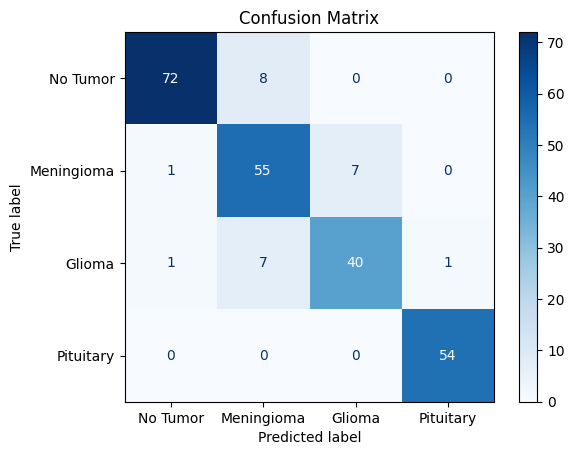

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Define class names
class_names = ['No Tumor', 'Meningioma', 'Glioma', 'Pituitary']

# Print classification report
print("\nClassification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [15]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Loss in the test:", test_loss)
print("Test Accuracy:", test_acc)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 429ms/step - accuracy: 0.8805 - loss: 0.3830
Loss in the test: 0.35626378655433655
Test Accuracy: 0.8983739614486694


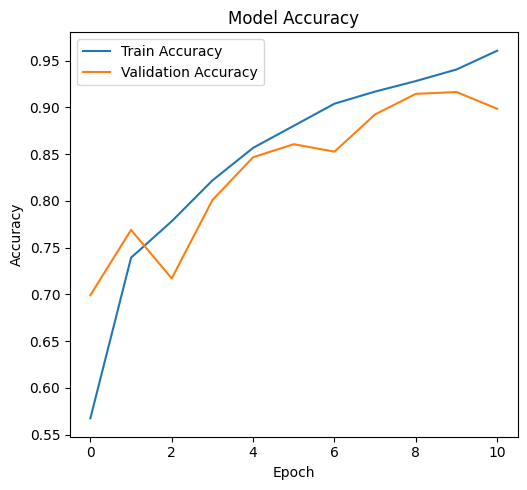

In [16]:
plt.figure(figsize=(10, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

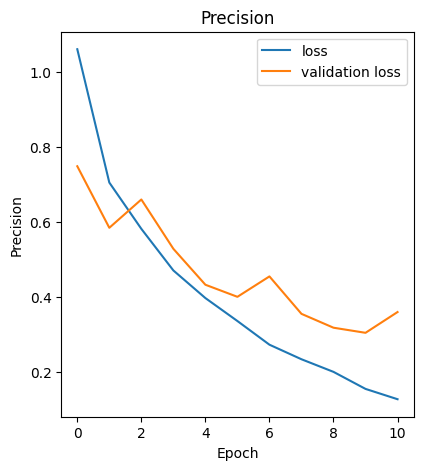

In [17]:

# Model loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.legend()
plt.title("Precision")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


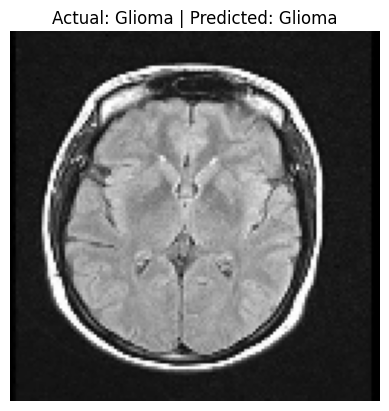

In [20]:
val_images = []
val_labels = []

for images, labels in val_ds:
    val_images.append(images.numpy())
    val_labels.append(labels.numpy())

val_images = np.concatenate(val_images)
val_labels = np.concatenate(val_labels)

# Choose a random index
idx = random.randint(0, len(val_images) - 1)

# Extract image and label
img = val_images[idx]
true_label = np.argmax(val_labels[idx])
# Predict using the model
img_expanded = np.expand_dims(img, axis=0)  # Model expects batch dimension
prediction = model.predict(img_expanded)
predicted_label = np.argmax(prediction)

# Show the image
plt.imshow(img)
plt.axis('off')
plt.title(f"Actual: {class_names[true_label]} | Predicted: {class_names[predicted_label]}")
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Tumour/custom_enhanced.keras')